<a href="https://colab.research.google.com/github/rincewind007/mish/blob/master/%5BPT_Devcon_2019%5D_PyTorch_TPU_ResNet18%2BMish_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch/TPU ResNet18/CIFAR10 Demo

This colab example corresponds to the implementation under [test_train_cifar.py](https://github.com/pytorch/xla/blob/master/test/test_train_cifar.py) and is TF/XRT 1.15 compatible.

Edit: Changed Relu to Mish algorithm!

<h3>  &nbsp;&nbsp;Use Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.


In [0]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

### [RUNME] Install Colab TPU compatible PyTorch/TPU wheels and dependencies
This may take up to ~2 minutes



In [2]:
DIST_BUCKET="gs://tpu-pytorch/wheels"
TORCH_WHEEL="torch-1.15-cp36-cp36m-linux_x86_64.whl"
TORCH_XLA_WHEEL="torch_xla-1.15-cp36-cp36m-linux_x86_64.whl"
TORCHVISION_WHEEL="torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl"

# Install Colab TPU compat PyTorch/TPU wheels and dependencies
!pip uninstall -y torch torchvision
!gsutil cp "$DIST_BUCKET/$TORCH_WHEEL" .
!gsutil cp "$DIST_BUCKET/$TORCH_XLA_WHEEL" .
!gsutil cp "$DIST_BUCKET/$TORCHVISION_WHEEL" .
!pip install "$TORCH_WHEEL"
!pip install "$TORCH_XLA_WHEEL"
!pip install "$TORCHVISION_WHEEL"
!sudo apt-get install libomp5

Uninstalling torch-1.2.0:
  Successfully uninstalled torch-1.2.0
Uninstalling torchvision-0.4.0:
  Successfully uninstalled torchvision-0.4.0
Copying gs://tpu-pytorch/wheels/torch-1.15-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 73.3 MiB/ 73.3 MiB]                                                
Operation completed over 1 objects/73.3 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-1.15-cp36-cp36m-linux_x86_64.whl...
\ [1 files][116.6 MiB/116.6 MiB]                                                
Operation completed over 1 objects/116.6 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  3.1 MiB/  3.1 MiB]                                                
Operation completed over 1 objects/3.1 MiB.                                      
Processing ./torch-1.15-cp36-cp36m-linux_x86_64.whl
ERROR: fastai 1.0.58 requires torchvision, which is not installed.
Processing ./torc

### Define Parameters



In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.distributed.data_parallel as dp
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torchvision
from torchvision import datasets, transforms

data_dir = "/tmp/cifar" #@param {type:"string"}
batch_size = 128 #@param {type:"integer"}
num_workers = 4 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
num_epochs = 20 #@param {type:"integer"}
num_cores = 8 #@param [8, 1] {type:"raw"}
log_steps = 20 #@param {type:"integer"}
metrics_debug = False #@param {type:"boolean"}

In [0]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(
        planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion * planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(
              in_planes,
              self.expansion * planes,
              kernel_size=1,
              stride=stride,
              bias=False), nn.BatchNorm2d(self.expansion * planes))

  def forward(self, x):
    out = self.bn1(self.conv1(x))
    out = out *( torch.tanh(F.softplus(out)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = out *( torch.tanh(F.softplus(out)))
    return out


class ResNet(nn.Module):

  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.bn1(self.conv1(x))
    out = out *( torch.tanh(F.softplus(out)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = torch.flatten(out, 1)
    out = self.linear(out)
    return F.log_softmax(out, dim=1)


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

In [7]:
norm = transforms.Normalize(
    mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
inv_norm = transforms.Normalize(
    mean=(-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010),
    std=(1/0.2023, 1/0.1994, 1/0.2010))  # For visualizations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    norm,
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    norm,
])
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform_train)
test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform_test)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers)

devices = (
    xm.get_xla_supported_devices(
        max_devices=num_cores) if num_cores != 0 else [])
print("Devices: {}".format(devices))
# Scale learning rate to num cores
learning_rate = learning_rate * max(len(devices), 1)
# Pass [] as device_ids to run using the PyTorch/CPU engine.
model_parallel = dp.DataParallel(ResNet18, device_ids=devices)

def train_loop_fn(model, loader, device, context):
  loss_fn = nn.NLLLoss()
  optimizer = context.getattr_or(
      'optimizer',
      lambda: optim.SGD(model.parameters(), lr=learning_rate,
                        momentum=momentum, weight_decay=5e-4))
  tracker = xm.RateTracker()

  model.train()
  for x, (data, target) in loader:
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    xm.optimizer_step(optimizer)
    tracker.add(batch_size)
    if x % log_steps == 0:
      print('[{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}\n'.format(
          device, x, loss.item(), tracker.rate(),
          tracker.global_rate(), time.asctime()), flush=True)

def test_loop_fn(model, loader, device, context):
  total_samples = 0
  correct = 0
  model.eval()
  data, pred, target = None, None, None
  for x, (data, target) in loader:
    output = model(data)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(target.view_as(pred)).sum().item()
    total_samples += data.size()[0]

  accuracy = 100.0 * correct / total_samples
  print('[Epoch {}] Global accuracy: {:.2f}%\n'.format(epoch, accuracy))
  return accuracy, data, pred, target


Files already downloaded and verified
Devices: ['xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7', 'xla:8']


In [10]:
# Start training
data, target, pred = None, None, None
for epoch in range(1, num_epochs + 1):
  model_parallel(train_loop_fn, train_loader)
  results = model_parallel(test_loop_fn, test_loader)
  results = np.array(results)  # for ease of slicing
  accuracies, data, pred, target = \
    [results[:,i] for i in range(results.shape[-1])]
  accuracy = sum(accuracies) / len(accuracies)
  print('Global accuracy: {:.2f}%'.format(accuracy))
  if metrics_debug:
    print(met.metrics_report())

[xla:6](0) Loss=0.99308 Rate=163.86 GlobalRate=163.85 Time=Fri Oct 11 20:37:53 2019
[xla:4](0) Loss=0.99258 Rate=162.64 GlobalRate=162.64 Time=Fri Oct 11 20:37:53 2019
[xla:3](0) Loss=1.02015 Rate=157.72 GlobalRate=157.72 Time=Fri Oct 11 20:37:53 2019
[xla:1](0) Loss=0.93746 Rate=156.66 GlobalRate=156.66 Time=Fri Oct 11 20:37:53 2019
[xla:2](0) Loss=0.95622 Rate=157.25 GlobalRate=157.23 Time=Fri Oct 11 20:37:53 2019
[xla:5](0) Loss=0.95819 Rate=163.04 GlobalRate=163.04 Time=Fri Oct 11 20:37:53 2019
[xla:7](0) Loss=1.17691 Rate=163.71 GlobalRate=163.71 Time=Fri Oct 11 20:37:53 2019
[xla:8](0) Loss=1.03201 Rate=168.61 GlobalRate=168.61 Time=Fri Oct 11 20:37:53 2019








[xla:6](20) Loss=0.95097 Rate=698.55 GlobalRate=837.98 Time=Fri Oct 11 20:37:56 2019
[xla:1](20) Loss=0.80692 Rate=696.09 GlobalRate=829.13 Time=Fri Oct 11 20:37:56 2019
[xla:3](20) Loss=0.80000 Rate=696.40 GlobalRate=830.43 Time=Fri Oct 11 20:37:56 2019
[xla:5](20) Loss=0.88219 Rate=698.69 GlobalRate=837.44 Time=Fri O

## Visualize Predictions

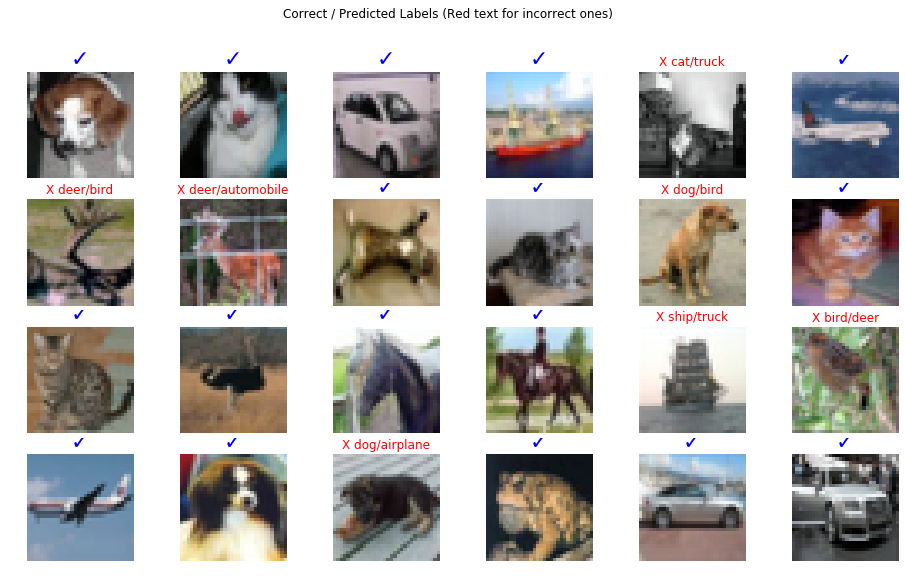

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

# Retrive tensors that is on TPU cores
M = 4
N = 6
images, labels, preds = data[0][:M*N].cpu(), \
  target[0][:M*N].cpu(), pred[0][:M*N].cpu()

fig, ax = plt.subplots(M, N, figsize=(16, 9))
plt.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

for i, ax in enumerate(fig.axes):
  img, label, prediction = images[i], labels[i], preds[i]
  img = inv_norm(img)
  img = img.permute(1, 2, 0) # (C, M, N) -> (M, N, C)
  ax.axis('off')
  label, prediction = label.item(), prediction.item()
  if label == prediction:
    ax.set_title(u'\u2713', color='blue', fontsize=22)
  else:
    ax.set_title(
        'X {}/{}'.format(CIFAR10_LABELS[label],
                         CIFAR10_LABELS[prediction]), color='red')
  ax.imshow(img)